In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from numpy import load
import matplotlib.pyplot as plt

In [6]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, num_layers, dropout):
        super(RegressionModel, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        for i in range(1, num_layers - 1):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        layers.append(nn.Linear(hidden_sizes[num_layers - 2], output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [7]:
def train_model(organ):

    #data loading and preprocessing
    data = load('training_arrays/merged_training_arrays/'+ organ + '_training_array.npy')

    X = data[:,:-1]
    y = data[:,-1]

    # Find rows containing NaN values in X
    nan_rows_X = np.isnan(X).any(axis=1)

    # Drop rows with NaN values from X and y
    X = X[~nan_rows_X]
    y = y[~nan_rows_X]

    # Scaling and splitting data
    min_max_scaler = MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

    batch_size = 256
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Setting device to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    hidden_sizes = [512, 256, 128, 64]
    model = RegressionModel(input_size=5, hidden_sizes=hidden_sizes, output_size=1, num_layers=5, dropout=0.1)
    model.to(device)  # Move the model to GPU if available

    #loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    #training
    num_epochs = 2000

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))
                val_loss += loss.item()
            val_loss /= len(val_loader)

        val_losses.append(val_loss)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    #save model
    torch.save(model.state_dict(), 'models/' + organ + '_model.pth')
    


In [8]:
organs_list = ['esophagus', 'aorta', 'pulmonary_artery', 'lung_lower_lobe_left', 'lung_lower_lobe_right',
                    'lung_upper_lobe_left', 'lung_upper_lobe_right', 'lung_middle_lobe_right', 
                    'heart_atrium_left', 'heart_atrium_right', 'heart_ventricle_left', 'heart_ventricle_right', 
                    'heart_myocardium', 'skin']

for organ in organs_list:
    train_model(organ)

Epoch [1/2000] - Train Loss: 173.7064 - Val Loss: 50.0603
Epoch [2/2000] - Train Loss: 45.4352 - Val Loss: 30.8343
Epoch [3/2000] - Train Loss: 32.4279 - Val Loss: 26.7097
Epoch [4/2000] - Train Loss: 28.3391 - Val Loss: 24.1248
Epoch [5/2000] - Train Loss: 25.6713 - Val Loss: 21.9187
Epoch [6/2000] - Train Loss: 24.0406 - Val Loss: 19.6956
Epoch [7/2000] - Train Loss: 21.7111 - Val Loss: 17.8658
Epoch [8/2000] - Train Loss: 20.1351 - Val Loss: 16.5558
Epoch [9/2000] - Train Loss: 19.0020 - Val Loss: 15.6245
Epoch [10/2000] - Train Loss: 18.1394 - Val Loss: 15.3161
Epoch [11/2000] - Train Loss: 17.5558 - Val Loss: 14.5541
Epoch [12/2000] - Train Loss: 16.6596 - Val Loss: 14.0712
Epoch [13/2000] - Train Loss: 16.3151 - Val Loss: 13.8501
Epoch [14/2000] - Train Loss: 15.9866 - Val Loss: 13.2519
Epoch [15/2000] - Train Loss: 15.1115 - Val Loss: 12.7719
Epoch [16/2000] - Train Loss: 14.6062 - Val Loss: 12.4257
Epoch [17/2000] - Train Loss: 14.3319 - Val Loss: 12.3001
Epoch [18/2000] - Trai

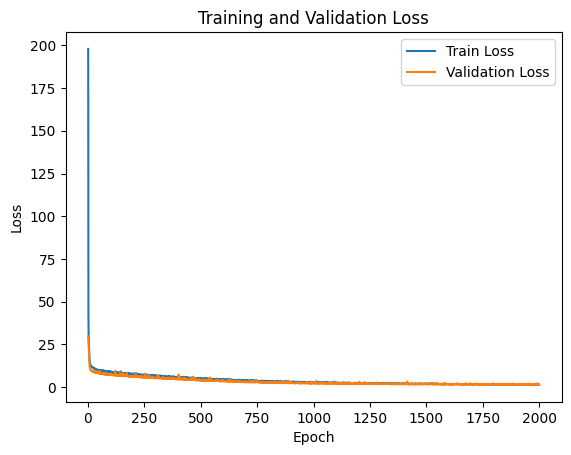

In [100]:
# Plot the losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()